In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb
from tqdm import tqdm

#### Output file

In [3]:
sourceFile = open("gpu_logs/ensemble_porto_40best.txt", 'w')

### Load the data

In [ ]:
df = pd.read_pickle("../datasets/df_location.pkl")
## Leaving the first house (public building out) due to its different profile
df = df.iloc[:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
num_samples_per_house = df.Location.value_counts()[1]
df.reset_index(drop=True, inplace=True)
df

In [ ]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [4]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [5]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)

def past_timesteps(df, number_of_timesteps):
    df = df.sort_values(by=['Location', 'Time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

#def past_timesteps(df, number_of_timesteps):
#    # Sort the dataframe by location and time
#    df = df.sort_values(by=['Location', 'Time'])
#
#    # Compute rolling window over time axis to extract past energy values for each location
#    energy_lags = [f"energy_lag_{i}" for i in range(1, number_of_timesteps+1)]
#    past_energy = df.groupby('Location')['Energy'].rolling(window=number_of_timesteps, min_periods=1).apply(np.mean())
#    # Add new columns to the dataframe for each past energy value
#    for i, energy_lag in enumerate(energy_lags):
#        df[energy_lag] = past_energy.apply(lambda x: x[-i-1] if isinstance(x, list) and len(x)>=i+1 else x)
#
#    # Drop rows with missing values
#    df.dropna(inplace=True)
#    df.reset_index(drop=True, inplace=True)
#
#    return df


def last_energy_points_full(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    other_feats = df.iloc[:,:2]
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = df.copy().iloc[:,2]
    y.iloc[:number_timesteps] = np.nan
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X = pd.concat([other_feats, X], axis=1)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    dataframe = pd.concat([X,y.rename('Energy')], axis=1)
    assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
    return dataframe
    

In [6]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

### Cross Validate

In [ ]:
#scores = validate(xgb.XGBRegressor(seed=0), X_train, y_train)
#cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),4)
#cv_r2 = np.round(scores['test_r2'].mean(),5)
#print("CV MSE: {} ".format(cv_mse))
#print("CV R2: {} ".format(cv_r2))
#metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))

## Leave 10 houses for test (demonstration)

In [ ]:
number_of_timesteps = 672

In [ ]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

In [ ]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

In [ ]:
df_new.to_csv("data/porto_oneweek.csv", index=False)

In [7]:
def test_leave_house_out(df, estimator, locations, filename):
    #df_new = past_timesteps(df, number_timesteps)
    #df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
    #df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5,6]).astype(int)
    #df_new['Hour'] = df_new['Time'].dt.hour
    test = df[df['Location'].isin(locations)]
    train = df[~df['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']
    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Predict  10 folds with 10 random houses for test

In [8]:
df = pd.read_csv("data/porto_best40features.csv")
df

,Time,Location,energy_lag_387,energy_lag_50,energy_lag_341,energy_lag_39,energy_lag_1,energy_lag_41,energy_lag_334,DayOfWeek,...,energy_lag_229,energy_lag_291,energy_lag_422,energy_lag_386,energy_lag_428,energy_lag_92,energy_lag_3,energy_lag_513,energy_lag_95,Energy
0,2019-01-08 00:00:00,0,2.661000,7.424000,4.279000,6.877000,3.952000,8.214000,7.054000,1,...,3.257000,2.459000,5.219000,2.499000,5.362000,2.349000,4.095000,3.137000,2.634000,4.940000
1,2019-01-08 00:15:00,0,2.499000,6.767000,4.530000,6.880000,4.940000,7.518000,6.929000,1,...,3.226000,2.396000,5.225000,3.609000,4.560000,2.688000,3.803000,3.093000,3.052000,4.149000
2,2019-01-08 00:30:00,0,3.609000,7.248000,4.281000,7.744000,4.149000,6.877000,6.717000,1,...,3.149000,2.824000,4.864000,2.351000,4.978000,2.567000,3.952000,3.879000,2.893000,4.401000
3,2019-01-08 00:45:00,0,2.351000,6.997000,6.357000,7.285000,4.401000,6.880000,7.790000,1,...,3.125000,3.066000,4.897000,2.843000,5.011000,2.765000,4.940000,3.490000,2.349000,4.431000
4,2019-01-08 01:00:00,0,2.843000,7.324000,6.192000,6.407000,4.431000,7.744000,5.729000,1,...,3.547000,3.152000,5.492000,2.949000,5.869000,3.054000,4.149000,2.569000,2.688000,3.988000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757659,2020-01-01 22:45:00,50,0.454855,0.625669,0.756937,0.437601,1.099100,0.374650,0.424639,2,...,0.082104,0.481770,0.429139,0.563585,0.099111,1.077717,0.481770,0.224600,0.752850,0.753222
1757660,2020-01-01 23:00:00,50,0.563585,0.429675,0.758175,0.441605,0.753222,0.358180,0.429675,2,...,0.107202,0.453906,0.426166,0.598713,0.090030,0.881889,0.453906,1.272473,0.935428,0.716855
1757661,2020-01-01 23:15:00,50,0.598713,0.458736,0.768412,0.277066,0.716855,0.437601,0.410480,2,...,0.070587,1.099100,0.190916,0.641933,0.079256,0.858855,1.099100,0.446187,0.715781,0.735802
1757662,2020-01-01 23:30:00,50,0.641933,0.420181,0.625669,0.413618,0.735802,0.441605,0.433184,2,...,0.088750,0.753222,0.105345,0.752850,0.097667,1.082588,0.753222,0.294279,1.077717,0.485237


In [9]:
df.isna().sum().sum()

0

In [10]:
#num_houses_test = 10

In [11]:
kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
locations = []
for _, test_index in kf.split(df['Location'].unique()):
    locations.append(test_index)
locations

[array([ 3, 12, 13, 17, 24, 30, 31, 32, 40, 43, 46]),
 array([ 4,  6,  8, 15, 19, 33, 36, 47, 48, 49]),
 array([ 0,  9, 11, 16, 25, 26, 27, 34, 44, 45]),
 array([ 1,  2,  5, 21, 23, 29, 35, 37, 39, 41]),
 array([ 7, 10, 14, 18, 20, 22, 28, 38, 42, 50]),
 array([ 0,  2, 10, 18, 23, 30, 36, 41, 45, 47, 49]),
 array([ 4,  8, 12, 20, 21, 26, 29, 31, 32, 33]),
 array([ 9, 14, 15, 22, 24, 37, 40, 42, 44, 48]),
 array([ 3,  5, 11, 17, 25, 28, 35, 38, 39, 50]),
 array([ 1,  6,  7, 13, 16, 19, 27, 34, 43, 46])]

In [12]:
df.Location.value_counts()

0     34464
38    34464
28    34464
29    34464
30    34464
31    34464
32    34464
33    34464
34    34464
35    34464
36    34464
37    34464
39    34464
26    34464
40    34464
41    34464
42    34464
43    34464
44    34464
45    34464
46    34464
47    34464
48    34464
49    34464
27    34464
25    34464
1     34464
12    34464
2     34464
3     34464
4     34464
5     34464
6     34464
7     34464
8     34464
9     34464
10    34464
11    34464
13    34464
24    34464
14    34464
15    34464
16    34464
17    34464
18    34464
19    34464
20    34464
21    34464
22    34464
23    34464
50    34464
Name: Location, dtype: int64

### Linear Regression

In [13]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 43)
Test set:  (379104, 43)

Iteration 1
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 2
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 3
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 4
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 5
Train set:  (1378560, 43)
Test set:  (379104, 43)

Iteration 6
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 7
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 8
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 9
Train set:  (1413024, 43)
Test set:  (344640, 43)


### XGBoost

In [14]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 43)
Test set:  (379104, 43)

Iteration 1
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 2
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 3
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 4
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 5
Train set:  (1378560, 43)
Test set:  (379104, 43)

Iteration 6
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 7
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 8
Train set:  (1413024, 43)
Test set:  (344640, 43)

Iteration 9
Train set:  (1413024, 43)
Test set:  (344640, 43)


### Random Forest

In [15]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 43)
Test set:  (379104, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 1
Train set:  (1413024, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 2
Train set:  (1413024, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 3
Train set:  (1413024, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 4
Train set:  (1413024, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 5
Train set:  (1378560, 43)
Test set:  (379104, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 6
Train set:  (1413024, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 7
Train set:  (1413024, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 8
Train set:  (1413024, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 9
Train set:  (1413024, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [16]:
print("\n\n\n", file=sourceFile)

In [17]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [18]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [19]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

### Feature Importance

In [20]:
print('Linear Regression\n')
for i,v in enumerate(model_lr.coef_):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

Linear Regression

Feature: 0, Score: -0.56053
Feature: 1, Score: 0.38186
Feature: 2, Score: -0.08430
Feature: 3, Score: 0.56710
Feature: 4, Score: 36.62927
Feature: 5, Score: 0.22773
Feature: 6, Score: 0.14344
Feature: 7, Score: 0.00404
Feature: 8, Score: 0.15532
Feature: 9, Score: -0.08642
Feature: 10, Score: -0.42093
Feature: 11, Score: -0.04396
Feature: 12, Score: 1.22050
Feature: 13, Score: -0.13819
Feature: 14, Score: -0.60524
Feature: 15, Score: -0.12321
Feature: 16, Score: -2.98507
Feature: 17, Score: -0.33728
Feature: 18, Score: -2.20837
Feature: 19, Score: 0.50842
Feature: 20, Score: -0.07320
Feature: 21, Score: -0.05593
Feature: 22, Score: 0.28947
Feature: 23, Score: 0.44291
Feature: 24, Score: -0.00996
Feature: 25, Score: 2.33936
Feature: 26, Score: -1.32758
Feature: 27, Score: 0.53639
Feature: 28, Score: -0.32048
Feature: 29, Score: 5.41097
Feature: 30, Score: 0.64431
Feature: 31, Score: -0.90468
Feature: 32, Score: -0.60952
Feature: 33, Score: 0.01412
Feature: 34, Score: 

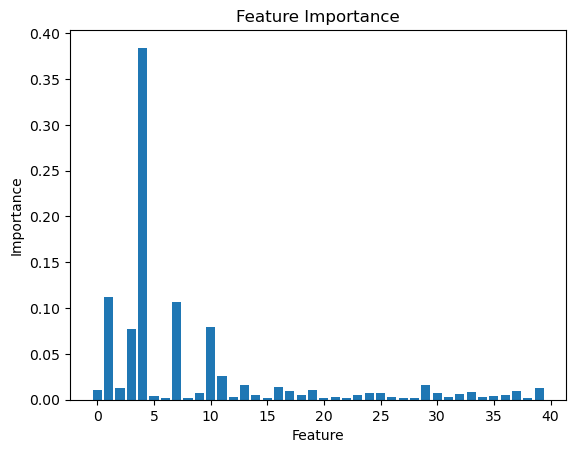

In [21]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

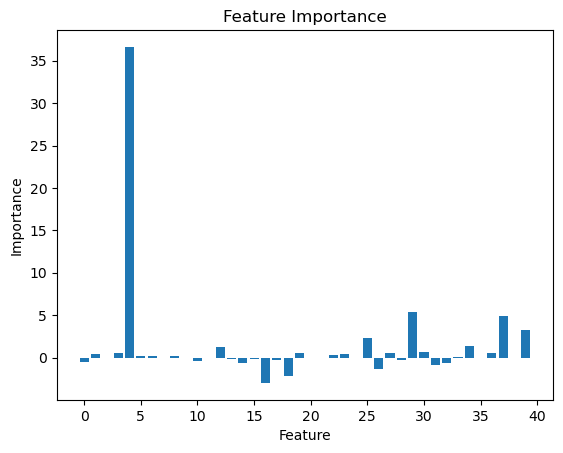

In [22]:
plt.bar(range(len(model_lr.coef_)),model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

In [ ]:
features = feature_importance.nlargest(40).index
features

In [ ]:
df_40 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_40

In [ ]:
df_40.to_csv("data/porto_best40features.csv", index=False)

In [23]:
sourceFile.close()